In [1]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import tqdm
import sys
import numpy as np
import sklearn
import scipy
import warnings
warnings.filterwarnings(action='once')


sc.settings.figdir=os.path.expanduser('~/WbFigures/DevAdultIntegrations')

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


In [ ]:
import scanorama
import pyliger
from harmony import harmonize
from scib_metrics.benchmark import Benchmarker


In [2]:
adata=sc.read_h5ad('/home/matthew.schmitz/Matthew/models/1.9.1.8.3_Dev/p4_adata.h5ad')
adata=adata[adata.obs['species']=='mouse',:]

In [3]:
mdata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/KDCbVelocityMouseWbAdultPresupervisionHumanOrthos.h5ad'))

In [4]:
adata.X.max()

7.584096

In [5]:
mdata.X.max()

7.492424

In [6]:
adata.obs['stage']='dev'
mdata.obs['stage']='adult'

/scratch/fast/16801816/ipykernel_210779/611306857.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['stage']='dev'


In [7]:
adata=sc.concat([adata,mdata],merge='unique')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/anndata/_core/merge.py:1357: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [8]:
del mdata
import gc
gc.collect()

769

In [9]:
adata

AnnData object with n_obs × n_vars = 768207 × 15299
    obs: 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'clean_cellname', 'full_cellname', 'msregion', 'stage'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means', 'mgi_symbol'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [21]:
from pynndescent import NNDescent

ref=NNDescent(,metric='correlation')
ref.query(flatarray[ao['supervised_name']==c2,:],k=5)


In [10]:
out_reductions='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/DevAdultIntegrations'

In [15]:
batch_key='batch'
discov_key='stage'
layer_key='UMIs'
MDE_KEY = "X_antipode_MDE"

In [16]:
# sc.pl.embedding(
#     adata,
#     basis=MDE_KEY,
#     color=["antipode_cluster",discov_key],legend_fontsize=6,legend_fontweight='normal',
#     legend_loc='on data',palette=sc.pl.palettes.godsnot_102
# )

In [17]:
# %%time
# import scvi
# scvi_model=scvi.model.SCVI.load('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.1_RunRetinaAllNoPsiSCVIsupervise',adata=adata) 
# SCVI_LATENT_KEY = "X_SCVI"
# adata.obsm[SCVI_LATENT_KEY] = scvi_model.get_latent_representation(adata)

# np.savetxt(os.path.join(out_reductions,"X_SCVI.csv"), adata.obsm["X_SCVI"], delimiter=",")

In [18]:
sc.pp.scale(adata,zero_center=False)
sc.pp.pca(adata)

In [19]:
%%time

adata.obsm["X_harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key=discov_key)

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).
CPU times: user 19min 44s, sys: 10min 53s, total: 30min 38s
Wall time: 16min 6s


In [33]:
%%time

# List of adata per batch
adata.obs[discov_key]=adata.obs[discov_key].astype('category')
batch_cats = adata.obs[discov_key].cat.categories
adata_list = [adata[adata.obs[discov_key] == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["X_Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["X_Scanorama"][adata.obs[discov_key] == b] = adata_list[i].obsm["X_scanorama"]


Found 15299 genes among all datasets
[[0.         0.09168761]
 [0.         0.        ]]
CPU times: user 10min 33s, sys: 1min 56s, total: 12min 30s
Wall time: 12min 7s


In [ ]:
%%time

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["spliced"]
# List of adata per batch
batch_cats = adata.obs[discov_key].cat.categories
adata_list = [bdata[bdata.obs[discov_key] == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["X_liger"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["X_liger"][adata.obs[discov_key] == b] = liger_data.adata_list[i].obsm["H_norm"]


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/pyliger/preprocessing/_scale.py:99: RuntimeWarning: divide by zero encountered in divide


In [11]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_SCVI", "X_antipode"]
obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]

In [35]:
for x in obsm_keys:
    try:
        np.savetxt(os.path.join(out_reductions,x+".csv"), adata.obsm[x], delimiter=",")
    except:
        print(x,'FAILED')


In [12]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_SCVI", "X_antipode"]

for x in obsm_keys:
    print(x)
    try:
        adata.obsm[x]=np.loadtxt(os.path.join(out_reductions,x+".csv"), delimiter=",")
    except:
        print(x,'FAILED')

X_pca
X_Scanorama
X_liger
X_liger FAILED
X_harmony
X_SCVI
X_SCVI FAILED
X_antipode
X_antipode FAILED


In [19]:
import antipode
import scvi

obsm_keys=[ "X_Scanorama", "X_harmony", "X_SCVI"]
for x in obsm_keys:
    print(x)
    try:
        adata.obsm[x+'_MDE'] = antipode.plotting.clip_latent_dimensions(scvi.model.utils.mde(adata.obsm[x],init='random'),0.1)
    except:
        print(x,'FAILED')

X_Scanorama


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              
X_harmony
INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/antipode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/matthew.schmitz/Matthew/utils/miniforge3/e ...


X_SCVI


KeyError: 'X_SCVI'

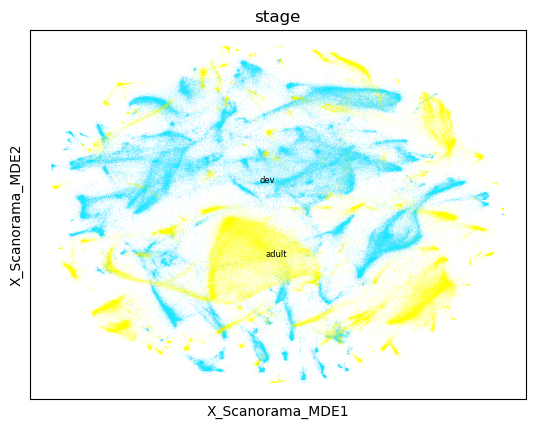

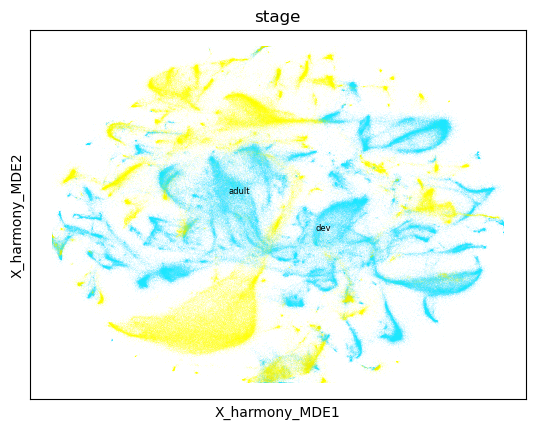

In [20]:
sc.pl.embedding(
    adata,
    basis='X_Scanorama_MDE',
    color=[discov_key],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis='X_harmony_MDE',
    color=[discov_key],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

In [ ]:
obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]
xdata=sc_analysis.select_k_cells(adata,'cell_class',50000)
output_dir=os.path.join(sc.settings.figdir,'cell_class')
try:
    os.mkdir(output_dir)
except:
    pass
bm = Benchmarker(
    xdata,
    batch_key="batch",
    label_key="cell_class",
    embedding_obsm_keys=obsm_keys,
    n_jobs=1,
)
bm.benchmark()
bm.plot_results_table(save_dir=output_dir)
bm.plot_results_table(save_dir=output_dir,min_max_scale=False)
df = bm.get_results(min_max_scale=False)
df.to_csv(os.path.join(output_dir,'scib-metrics.csv'))

In [ ]:
obsm_keys=[x for x in obsm_keys if x in adata.obsm.keys()]
xdata=sc_analysis.select_k_cells(adata,'level_2',50000)
output_dir=os.path.join(sc.settings.figdir,'level_2')
try:
    os.mkdir(output_dir)
except:
    pass
bm = Benchmarker(
    xdata,
    batch_key="batch",
    label_key="cell_class",
    embedding_obsm_keys=obsm_keys,
    n_jobs=1,
)
bm.benchmark()
bm.plot_results_table(save_dir=output_dir)
bm.plot_results_table(save_dir=output_dir,min_max_scale=False)
df = bm.get_results(min_max_scale=False)
df.to_csv(os.path.join(output_dir,'scib-metrics.csv'))

In [ ]:
obsm_keys=["X_pca", "X_Scanorama", "X_liger", "X_harmony", "X_SCVI", "X_antipode"]
for x in obsm_keys:
    print(x)
    try:
        adata.obsm[x]=np.loadtxt(os.path.join(out_reductions,x+".csv"), delimiter=",")
    except:
        print(x,'FAILED')

In [ ]:
def taxonomy_entropy(adata, annotations, nearest_neighbors = 15, dim = "X_scVI"):
    """Compute entropy (mixing) of annotations within a cells local neighborhood. 
    Author: Nelson Johansson
    Args:
        adata (.h5ad): adata object with `annotations` in adata.obs.
        annotations (list of str): Cell level annotations.
        nearest_neighbors (int): Number of nearest neighbors.
        dim (str): Dimensionality reduction within adata.obsm. Should be "X_scVI" but can be "X_umap".
    Example:
        adata = sc.read_h5ad("YOUR_ANNDATA.h5ad")
        adata = taxonomy_entropy(adata = adata, annotations=["Neighborhood", "Subclass"])
    Returns:
        adata
    """
    ## Build nearest neighbor tree for fast lookup
    print("Building nearest neighbor tree.")
    nnTree = sklearn.neighbors.KDTree(adata.obsm[dim])
    nearest_dist, nearest_ind = nnTree.query(adata.obsm[dim], k=nearest_neighbors)
    ##
    for anno in annotations:
        print("Computing entropy on: " + anno)
        adata.obs[dim+"_"+anno + "_entropy"] = -1 ## Initialize with a value outside range of entropy.
        for cell in tqdm.tqdm(range(0, adata.shape[0])):
            nearest_neighbors = nearest_ind[cell,:]
            adata.obs.loc[adata.obs.index[cell], dim+"_"+anno + "_entropy"] = scipy.stats.entropy(adata.obs.loc[adata.obs.index[nearest_neighbors],anno].value_counts()/len(nearest_neighbors))
    return adata


In [ ]:
#xdata=sc_analysis.select_k_cells(adata,'level_2',10000)
xdata=adata[np.random.choice(adata.obs.index,50000,replace=False),:]

In [ ]:
for x in obsm_keys:
    print(x)
    try:
        xdata=taxonomy_entropy(xdata,['species','batch'],nearest_neighbors = 30,dim=x)
    except:
        print(x,'FAILED')

In [ ]:
df=xdata.obs.loc[:,[x for x in xdata.obs.columns if 'entropy' in x]].melt()
df.columns=['variable','entropy']
df

In [ ]:
seaborn.boxplot(data=df,x='variable',y='entropy',)
plt.xticks(rotation=90)
plt.savefig(os.path.join(sc.settings.figdir,'entropy_violins.svg'))
plt.show()

In [ ]:
xdata.obs.loc[:,[x for x in xdata.obs.columns if 'entropy' in x]].to_csv(os.path.join(sc.settings.figdir,'entropy_table.csv'))